# Generalized Langevin equation solution

Following *Andrew D. Baczewski1 and Stephen D. Bond Numerical Integration of the Extended Variable Generalized Langevin Equation with a
Positive Prony Representable Memory Kernel*.

In this notebook, the memory kernel will be 

$$
\Gamma(t) = \gamma \left( 2 \delta(t) + \Gamma_m \right)
$$

In particular, for a Jeffreys fluid:

$$
\Gamma(t) = \gamma \left( 2 \delta(t) + \frac{\Delta}{\tau} \exp(-t / \tau) \right)
$$

Library import

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

Parameter inicialization

In [134]:
KT = 1.0
GAMMA = 1.0
MASS = 5.0e-4

FC = 0.0

TIME_STEP = 0.001
N_STEP = 10000

Prony parameters

El tamaño de ck y tk tiene que coincidir con Nk

In [135]:
def prony(t, F, m):
    #  Input  : real arrays t, F of the same size (ti, Fi)
    #         : integer m - the number of modes in the exponential fit
    #  Output : arrays a and b such that F(t) ~ sum ai exp(bi*t)"""

	# Solve LLS problem in step 1
	# Amat is (N-m)*m and bmat is N-m*1
	N    = len(t)
	Amat = np.zeros((N-m, m))
	bmat = F[m:N]

	for jcol in range(m):
		Amat[:, jcol] = F[m-jcol-1:N-1-jcol]
		
	sol = np.linalg.lstsq(Amat, bmat)
	d = sol[0]

	# Solve the roots of the polynomial in step 2
	# first, form the polynomial coefficients
	c = np.zeros(m+1)
	c[m] = 1.
	for i in range(1,m+1):
		c[m-i] = -d[i-1]

	u = poly.polyroots(c)
	b_est = np.log(u)/(t[1] - t[0])

	# Set up LLS problem to find the "a"s in step 3
	Amat = np.zeros((N, m))
	bmat = F

	for irow in range(N):
		Amat[irow, :] = u**irow
		
	sol = np.linalg.lstsq(Amat, bmat)
	a_est = sol[0]

	return a_est, -b_est

In [136]:
Nk = 1 # Number of Prony modes
# c_v = [0.25]
# tau_v = [0.25]

# if len(c_v) != Nk or len(tau_v) != Nk:
#     print('### ERROR ###')
#     print('EL TAMAÑO DE CK Y TK TIENE QUE COINCIDIR CON EL NÚMERO DE MODOS DE PRONY')

Exponential kernel

In [137]:
q = 10
tau_m = 1.0

t_data = np.linspace(TIME_STEP, N_STEP*TIME_STEP, 200)
data = q * GAMMA / tau_m * np.exp(-t_data / tau_m)

# Fit the Prony model to the function 'data' to obtain the Prony coefficients
a_v, b_v = prony(t_data, data, Nk)

/tmp/ipykernel_23469/855062173.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol = np.linalg.lstsq(Amat, bmat)
/tmp/ipykernel_23469/855062173.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol = np.linalg.lstsq(Amat, bmat)


In [138]:
# Convert the coefficients of the fit to ck and tauk
tau_v = 1.0 / b_v
c_v = a_v * tau_v

In [139]:
print('ak coefficients', a_v)
print('bk coefficients', b_v)

ak coefficients [9.990005]
bk coefficients [1.]


In [140]:
print('C coefficients', c_v)
print('tau coefficients', tau_v)

C coefficients [9.990005]
tau coefficients [1.]


Plot of the kernel function and its fit

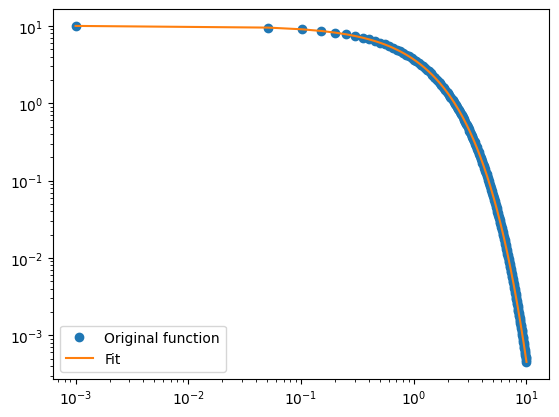

In [141]:
K_v = []
for time in t_data:
    K = 0.0
    for ck, tauk in zip(c_v, tau_v):
        K += (ck/tauk) * np.exp(-time/tauk)
    
    K_v.append(K)


plt.figure()
plt.loglog(t_data, data, 'o', label='Original function')
plt.loglog(t_data, K_v, label='Fit')
plt.legend()
plt.show()

Initial values

In [142]:
x0 = 0.0
v0 = 0.0
s0 = np.zeros(Nk)
time = 0 # Initial time

# Set the values
x = x0
v = v0
s = s0


$\theta_k$ and $\alpha_k$ values

Method 1

In [143]:
theta = np.zeros(Nk)
alpha = np.zeros(Nk)

for k in range(Nk):
    theta[k] = 1 - TIME_STEP / tau_v[k]
    alpha[k] = np.sqrt(TIME_STEP) / tau_v[k]


Generalized Langevin Equation (GLE) integration

Unidimensional (at the moment)

In [144]:
FbN = np.sqrt(2 * KT * GAMMA / TIME_STEP)

In [145]:
REP = 200

msd = np.zeros(N_STEP)

for rep in range(REP):

    if rep%10 == 0:
        print(rep)

    # Set the  initial values
    x = x0
    v = v0
    s = s0
    time = 0.0

    time_v = []
    pos = []
    vel = []

    for _ in range(N_STEP):
        # Random number generation
        B = np.random.normal(0, 1, Nk)
        Bn = np.random.normal(0, 1, 1)
        
        # Update v half step
        v = v + TIME_STEP / (2 * MASS) * (FC - GAMMA * v + FbN * Bn[0]) + TIME_STEP / (2 * MASS) * np.sum(s)
  
        # Update x a complete step
        x = x + TIME_STEP * v

        # Update every sk a complete step
        for k, sk in enumerate(s):
            s[k] = theta[k] * s[k] - (1 - theta[k]) * c_v[k] * v + alpha[k] * np.sqrt(2 * KT * c_v[k]) * B[k] 

        # Update v for other half step
        v = v + TIME_STEP / (2 * MASS) * (FC - GAMMA * v + FbN * Bn[0]) + TIME_STEP / (2 * MASS) * np.sum(s)

        time += TIME_STEP
        
        time_v.append(time)
        pos.append(x)
        vel.append(v)
    
    msd += np.multiply(pos, pos)

msd = msd / REP

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


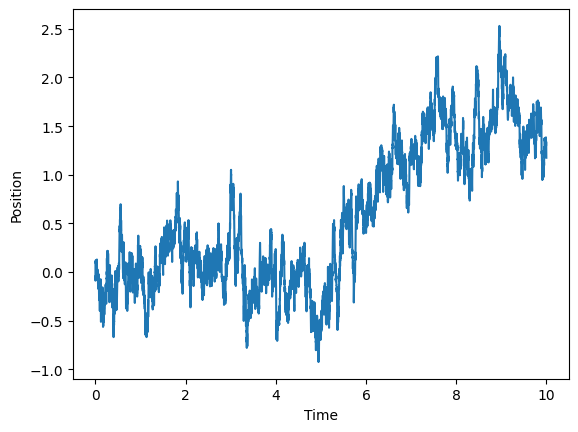

In [146]:
plt.figure()
plt.plot(time_v, pos)
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

In [147]:
def msd_theo(t,kT,q,zeta_v,tau_m):
    return 2*kT*(t + q/(1+q) * tau_m * (1 - np.exp(-(1+q)*t/tau_m)))/(zeta_v*(1+q))

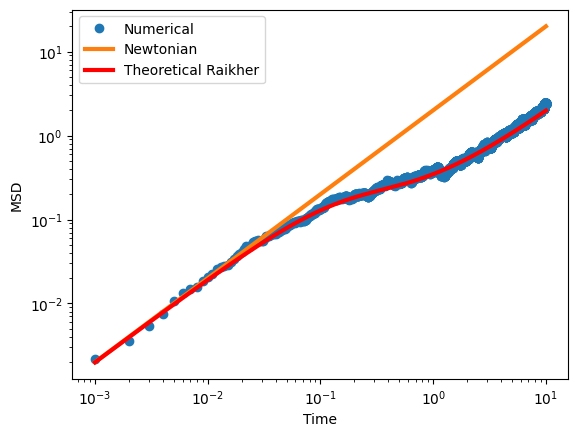

In [148]:
plt.figure()
plt.loglog(time_v, msd, 'o', label='Numerical')
#plt.loglog(time_v, 2 * KT * np.sin(npower*np.pi) / (npower * GAMMA) * np.power(time_v, npower), label='Power-law n='+str(npower))
plt.loglog(time_v, 2 * KT / GAMMA * np.array(time_v), label='Newtonian', linewidth = 3.0)
plt.loglog(time_v, msd_theo(np.array(time_v), KT, q, GAMMA, tau_m), label='Theoretical Raikher', linewidth = 3.0, color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MSD')
#plt.ylim(1e-2, 1e1)
plt.show()